## import

 ##### Notice the version of scvelo

In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders,dendrogram,linkage
from sklearn.decomposition import PCA
from scipy.linalg import inv
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

print(scv.__version__)

0.2.5


In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [3]:
import seaborn as sns
from GE_utils import *

## setting

In [4]:
#### Remember to restart kernel every time!
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
#data_name = 'EG_ab_dyn.h5ad'
data_name = 'EG_ab_bin.h5ad'
#data_name = 'processed bonemarrow.h5ad'
#data_name = 'lung.h5ad'
#data_name = 'DentateGyrus/DentateGyrus.loom'
adata0=scv.read(data_path+data_name, cache=True)

model_name = 'EG_ab_bin'

subfolder = 'Adjacency'
result_path = 'results/'+model_name+'/'+subfolder+'/'

import os
folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)


## Data

### processing

In [6]:
adata0

AnnData object with n_obs × n_vars = 2322 × 514
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'log1p', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

saving figure to file results/EG_ab_bin/Adjacency/clusters.png


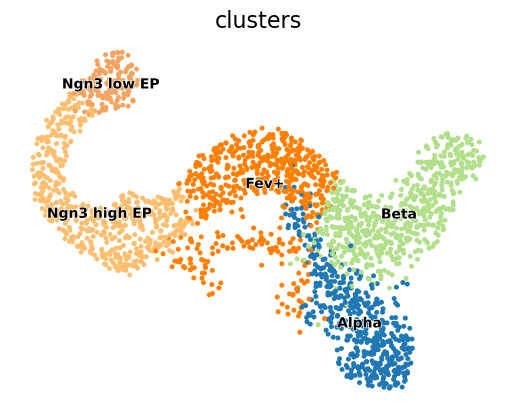

In [7]:
clusters = adata0.obs['clusters']
scv.pl.scatter(adata0, color="clusters",basis='umap', fontsize=16, save=result_path+'clusters.png')

In [8]:
# #-------data preprocessing: loop to remove zero and low variance genes
# while True:
#     k_nei=10
#     #adata=adata0.copy()
#     scv.pp.neighbors(adata0, n_neighbors=k_nei)
#     scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)
#     zero_gene_num = np.sum(np.sum(adata0.layers['Ms'],axis=0) == 0)
#     print('zero_gene_num',zero_gene_num)
#     if zero_gene_num == 0:
#         lowvar_num = np.sum(np.var(adata0.layers['Ms'],0)<1e-1)
#         print('lowvar_num',lowvar_num)
#         if lowvar_num == 0:
#             break
#         else:
#             adata0 = adata0[:,(np.var(adata0.layers['Ms'],0)>1e-1)]
#     else:
#         adata0 = adata0[:,(np.sum(adata0.layers['Ms'],axis=0) != 0)]

## ------data preprocessing: single run
k_nei=10
scv.pp.neighbors(adata0, n_neighbors=k_nei)
scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
scv.pp.pca(adata0,n_comps=50)
adata0

AnnData object with n_obs × n_vars = 2322 × 514
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'log1p', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [10]:
scv.tl.velocity(adata0)
adata0
# scv.tl.velocity_graph(adata0)
# scv.tl.velocity_pseudotime(adata0)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 2322 × 514
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'log1p', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [11]:
gene_arr=adata0.var.index.values
X_pca=adata0.obsm['X_pca']
# cell_vpt=adata0.obs['velocity_pseudotime'].values#cell_vpt = adata0.obs['latent_time'].values#
cell_vpt=adata0.obs['palantir_pseudotime'].values
color_label = cell_vpt
Xs=adata0.layers['Ms']#adata.X.A#
X_pca.shape

(2322, 50)

In [12]:
cell_nei=adata0.uns['neighbors']['indices']
def Nei_matrices(cell_nei,k_nei,adata):    
    row =np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
    col=cell_nei.flatten()
    w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
    adj_val=np.ones(col.shape)
    dc=np.amax(w_val)
    nei_w=[]
    rho_arr=[]
    for i in range(cell_nei.shape[0]):
        dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
        rho=np.sum(np.exp(-dij**2/dc**2))
        nei_w.append(np.exp(-dij**2/dc**2)/rho)
        rho_arr.append(rho)
    rho_arr=np.array(rho_arr)/np.amax(rho_arr)
    nei_w=np.array(nei_w)
    A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    W_mat=csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    Nei_mat=csr_matrix((nei_w.flatten(), (row, col)), shape=(adata.shape[0], adata.shape[0]))
    return nei_w,A_mat,W_mat,Nei_mat
nei_w,A_mat,W_mat,Nei_mat = Nei_matrices(cell_nei,k_nei,adata0)

In [13]:
velocity = np.array(adata0.layers['velocity'])
velocity_gene = adata0.var['velocity_genes']

In [14]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

## Gaussian embedding

### encoder

In [15]:
epochs = 200
nsamples = 15
learning_rate = 1e-3
seed = 0
# n_workers = 4
K = 3# !!!!!!!!!! K should be large enough

print(subfolder)
if subfolder == 'Adjacency':
    A, Input_matrix = A_mat, 'Adjacency'  ##连接矩阵
elif subfolder == 'distance':
    A, Input_matrix = W_mat, 'distance'   ##距离矩阵
elif subfolder == 'weighted':
    A, Input_matrix = Nei_mat, 'weighted' ##权重矩阵

X=Xs
z=color_label
n = A.shape[0]

print('处理图数据')
train_data = AttributedGraph(A, X, z, K, directed=True, Input_matrix=Input_matrix) ###


Adjacency
处理图数据


In [16]:
L = 6
encoder = Encoder(X.shape[1], L)

In [17]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [18]:
#LAMBDA = 1e-6
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()
    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    
    #print(batch_idx,mu,sigma)
    #loss = BPR_loss(mu,sigma,LAMBDA)
    #print(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        mu,sigma = encoder(torch.tensor(data[0][0]))
        print(batch_idx,loss,torch.mean(sigma**2,axis=0))
    loss.backward()
    optimizer.step()

0 tensor(3.4452e+10, grad_fn=<DivBackward0>) tensor([13.9781, 23.7488, 20.7252,  0.2114,  4.8443,  0.3778],
       grad_fn=<MeanBackward1>)
10 tensor(5.1904e+08, grad_fn=<DivBackward0>) tensor([ 46.6698,  42.5928,  74.0934, 100.0602,  99.3384, 146.8383],
       grad_fn=<MeanBackward1>)
20 tensor(4.7845e+08, grad_fn=<DivBackward0>) tensor([ 83.8102,  56.9724, 120.9184, 153.9646, 152.2878, 234.5978],
       grad_fn=<MeanBackward1>)
30 tensor(4.3726e+08, grad_fn=<DivBackward0>) tensor([108.9821,  62.9519, 149.7755, 182.5056, 176.3723, 293.6256],
       grad_fn=<MeanBackward1>)
40 tensor(4.1244e+08, grad_fn=<DivBackward0>) tensor([123.5414,  80.8365, 172.1273, 199.2437, 190.3118, 325.5857],
       grad_fn=<MeanBackward1>)
50 tensor(3.9887e+08, grad_fn=<DivBackward0>) tensor([133.6928,  94.7137, 185.9265, 215.4103, 201.5693, 349.4253],
       grad_fn=<MeanBackward1>)
60 tensor(3.8927e+08, grad_fn=<DivBackward0>) tensor([139.6538, 106.4160, 192.7926, 231.8746, 211.3958, 373.5064],
       gra

In [19]:
sigma = sigma.detach().numpy()

In [20]:
sigma_cluster = []
for i in np.unique(clusters):
    sigma_cluster.append(sigma[clusters==i])
sigma_cluster = np.vstack(sigma_cluster)

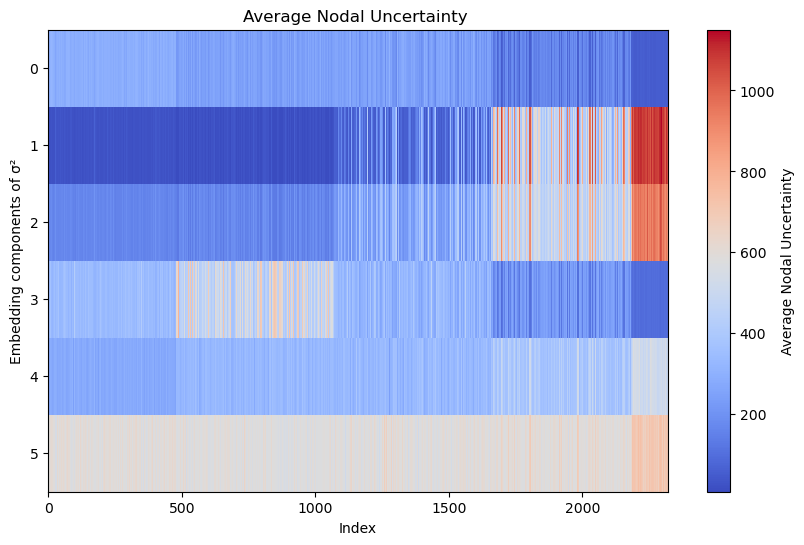

In [21]:
# Create the heatmap
plt.figure(figsize=(10, 6))
heatmap = plt.imshow(sigma_cluster.T**(2), aspect='auto', cmap='coolwarm', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('Average Nodal Uncertainty')

# Set labels
plt.title('Average Nodal Uncertainty ')
plt.xlabel('Index')
plt.ylabel('Embedding components of σ²')
plt.show()

### FIM and save

In [22]:
result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)
torch.save(encoder,result_path+'encoder.pt')

In [23]:
GE_results = Get_GE_results(encoder,X,GE_eigen=None)
np.savez(result_path+'GE_results.npz',GE_results)

In [24]:
GE_results.keys()

dict_keys(['mu_learned', 'sigma_learned', 'latent_z', 'pMu_pX', 'pSgm_pX', 'Fisher_g'])

## Read

In [15]:
[k_nei,K,L] = [10,3,6]
read_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
GE_results = np.load(read_path+'GE_results.npz',allow_pickle=True)['arr_0'].item()

## Downstream

In [16]:
GE_results.keys()

dict_keys(['mu_learned', 'sigma_learned', 'latent_z', 'pMu_pX', 'pSgm_pX', 'Fisher_g'])

In [17]:
mu_learned = GE_results['mu_learned']
sigma_learned = GE_results['sigma_learned']
latent_z = GE_results['latent_z']
Fisher_g = GE_results['Fisher_g']
pMu_pX = GE_results['pMu_pX']
pSgm_pX = GE_results['pSgm_pX']

In [18]:
X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]

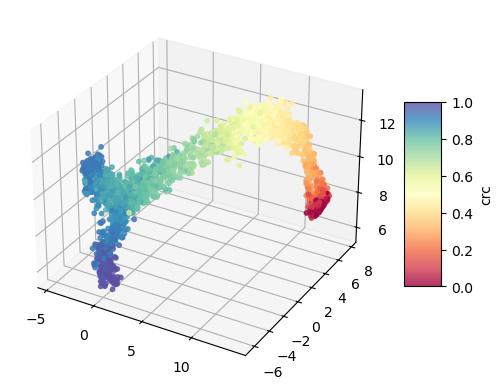

In [19]:
###CRC ON EMBEDDIGN
if L>2:
    max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
    plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
       color=color_label,color_bar_name='crc',save_name=result_path + f'cl on embedding{K}_{L}.png')

### Eigenvec

In [20]:
new_para_name = 'eigengene'
# new_para_name = 'hotspot'
# new_para_name = ''

In [21]:
X = Xs

if new_para_name == 'PCA':
    X = X_pca
if new_para_name == 'eigengene':
    # X = compute_x_eigen(X)
    # print('X shape:',X.shape)
    # np.save(result_path+'cell_eigengene_X'+'.npy',X)
    X = np.load(read_path+'cell_eigengene_X'+'.npy').astype(np.float32)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'eigengene_xiaohe':
    eigenname = 'data/eigengene/!EG_ab_dyn_processed10_nModule_7_eigengene_Power_9_deepSplit_1_minSize_10.csv'
    df = pd.read_csv(eigenname)
    df = df.drop('MEgrey',axis=1)
    df = np.array(df)
    print(df)
    # X = compute_x_eigen(X)
    X = df.astype(np.float32)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'hotspot':
    # cell_hs_X = np.load(read_path+'cell_hs_X'+'.npy')
    # X = cell_hs_X.astype(np.float32)
    # X = compute_x_hs(X,adata0,k_nei)
    # X = X.astype(np.float32)
    # np.save(result_path+'cell_hs_X'+'.npy',X)
    X = np.load(read_path+'cell_hs_X'+'.npy').astype(np.float32)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)

100%|██████████| 200/200 [00:00<00:00, 653.68it/s]


In [22]:
print(np.mean(pMu_pX),np.mean(pSgm_pX))

-0.16513475360080743 -0.424707572111805


In [23]:
stiffnum,diagFIgene,Eigenvec,Eigenval = FIM_new(pMu_pX,pSgm_pX,Fisher_g)

Calculating Fisher Information Matrix of genes...


100%|██████████| 2322/2322 [00:00<00:00, 43773.73it/s]


eigenvec setting

In [24]:
result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
result_path_eigenvec = result_path +f'{new_para_name}_Eigenvec/'
folder = os.path.exists(result_path_eigenvec)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path_eigenvec)

In [25]:
read_path = 'results/'+model_name+'/'+f'{subfolder}/k_nei={k_nei}/'#+ f'k_nei={k_nei}/'
clusters = adata0.obs['clusters'] ##在这行是之后使用的细胞聚类方法，可以自行更换比如PAGA
if 'beta' in result_path_eigenvec:
    clusters = np.load(read_path+'EG_rc_beta_nei.npy') 
elif 'alpha' in result_path_eigenvec:
    clusters = np.load(read_path+'EG_rc_alpha_nei.npy')
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

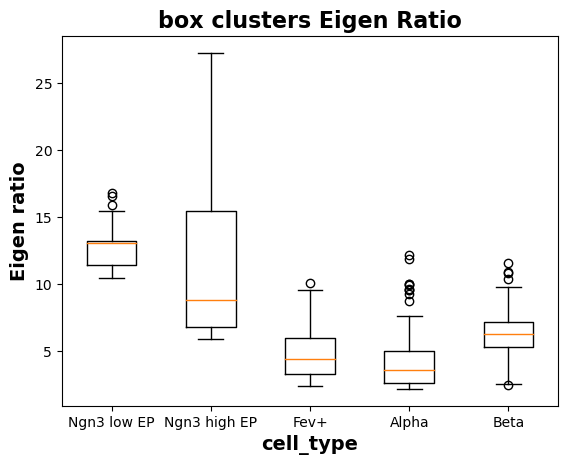

In [26]:
##画图，前2特征值比值图
PLT_box(clusters,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path_eigenvec+f'box Eigen Ratio {new_para_name}'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=cell_vpt)

In [27]:
from GE_utils import hierarchical_clustering

3 0.05000000447034836


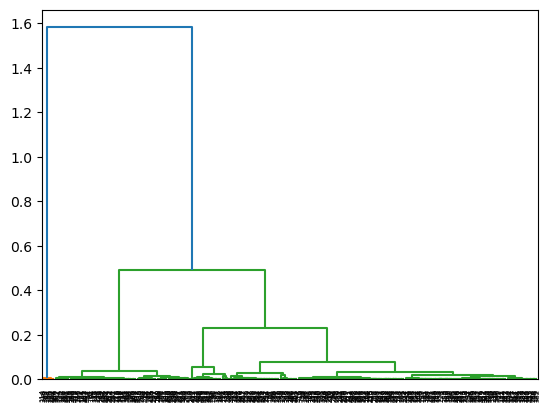

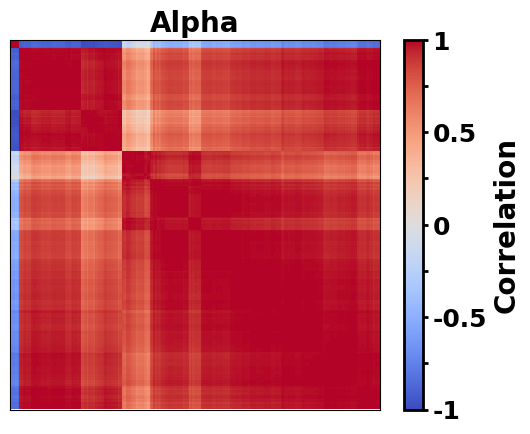

[5 6 6 3 6 6 3 6 2 6 6 5 6 2 6 2 2 6 2 6 2 6 6 6 6 3 6 2 6 6 3 5 6 2 6 6 5
 6 6 3 2 6 6 2 6 6 5 6 6 2 2 6 6 2 6 6 5 2 6 2 6 3 1 6 2 5 5 6 6 5 2 2 2 6
 1 1 1 6 5 6 6 3 3 6 5 6 2 6 2 2 6 2 5 2 2 2 2 2 6 3 2 5 2 6 2 2 6 2 6 5 6
 6 5 6 1 6 2 6 6 2 6 2 3 6 5 2 6 6 6 2 6 2 6 6 6 2 6 5 5 3 6 5 6 6 3 2 2 5
 6 6 5 5 5 3 6 2 6 6 2 6 6 6 5 2 6 2 2 6 6 6 6 6 3 6 6 2 6 5 2 2 2 6 6 2 1
 6 6 6 2 6 6 5 6 6 6 6 3 6 6 6 6 6 3 2 2 6 6 2 6 2 6 2 5 6 3 6 2 2 5 2 6 6
 6 2 6 5 6 6 6 2 6 6 3 5 6 5 6 6 6 2 3 2 6 6 6 2 6 2 2 2 6 5 6 1 6 6 2 6 5
 2 1 5 6 2 2 6 2 6 2 2 2 2 2 6 5 6 5 5 3 6 6 1 2 6 6 5 6 2 6 3 6 2 6 6 5 6
 6 5 6 6 6 5 2 2 2 5 5 6 2 6 5 6 6 3 6 6 5 6 1 2 6 2 3 5 2 5 6 2 6 6 2 6 6
 6 6 2 2 4 6 6 2 6 3 6 6 6 6 6 5 3 6 2 6 5 6 6 2 3 6 6 2 5 2 1 2 6 6 6 5 2
 6 6 6 6 2 6 6 2 6 2 2 3 6 2 2 6 5 5 2 6 2 3 2 5 5 6 3 2 5 6 2 6 5 6 2 6 6
 2 6 6 2 3 3 6 2 6 6 6 2 6 3 6 6 6 6 2 2 6 3 3 5 6 6 6 6 2 6 2 2 6 6 2 6 2
 1 6 2 6 6 6 6 6 6 6 6 3 3 2 5 2 2 2 5 5 6 6 5 5 6 5 5 2 6 2 2 6 2]


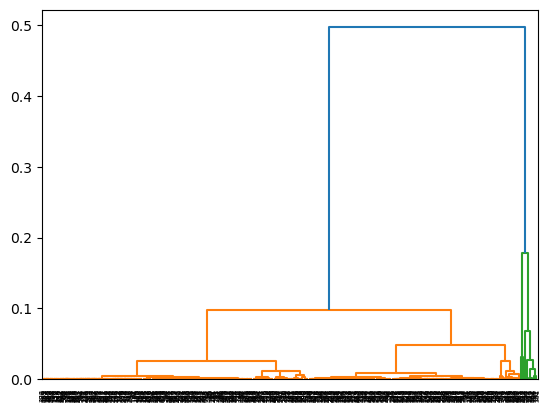

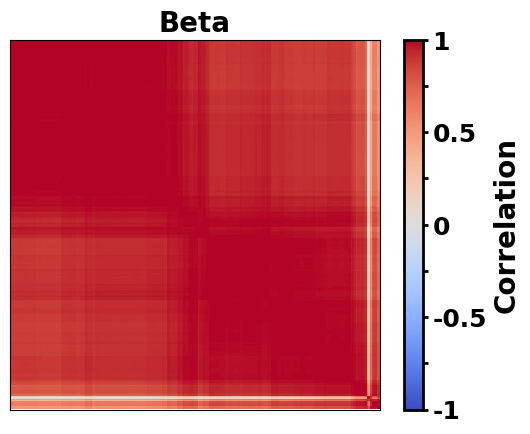

[2 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2 2 2 1 5 2 1 2 1 2 1 1 2 1 2 1 1
 2 2 1 1 1 5 1 2 1 2 1 1 2 2 2 2 1 4 1 1 1 1 2 1 2 1 1 2 1 1 2 2 1 2 2 2 1
 1 1 2 2 1 1 1 5 2 1 2 1 2 1 1 2 2 1 1 2 1 1 1 2 1 1 1 1 2 1 2 1 1 2 2 1 2
 1 1 2 1 2 2 2 1 2 2 1 1 1 2 1 2 2 1 1 1 5 1 1 2 1 1 1 2 2 1 2 2 1 1 2 1 1
 2 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 2 1 2 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 1
 2 1 1 1 1 1 1 5 1 2 2 1 2 1 1 2 1 2 2 2 1 5 1 2 2 2 3 2 2 1 2 2 1 1 2 2 1
 2 2 2 2 5 1 1 2 1 2 3 1 2 1 2 1 1 1 1 1 1 2 2 2 2 1 2 1 1 2 1 2 2 2 1 2 2
 1 1 1 1 1 1 1 2 1 1 1 1 5 2 1 1 2 2 2 2 2 1 1 1 1 2 1 2 1 1 2 2 5 2 1 1 2
 1 1 1 1 2 5 2 2 2 1 1 1 2 2 1 1 2 2 1 2 1 1 1 1 2 1 2 2 1 2 1 2 2 2 1 2 5
 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 1 1 1 2 1 1 1 2 1 1
 1 1 1 1 1 1 2 1 1 2 2 2 2 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 2 1 1 1 2 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 1 2 2 1 2 2 1 3 1 2 2 2 4 1 2 1 1 1 2 1 1 2 1 2 1 1
 4 1 1 2 2 1 1 1 2 2 2 1 1 1 1 1 2 1 2 2 5 1 2 2 1 2 2 2 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 2 1 2 1 1 1 

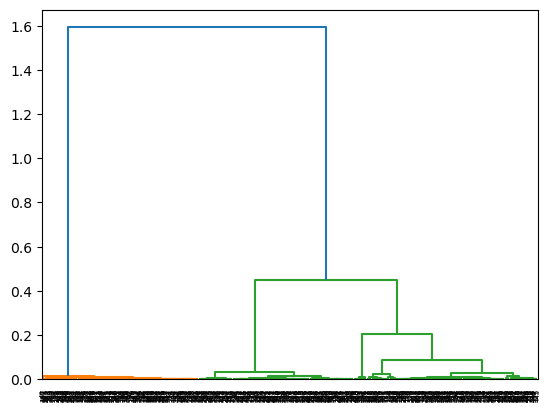

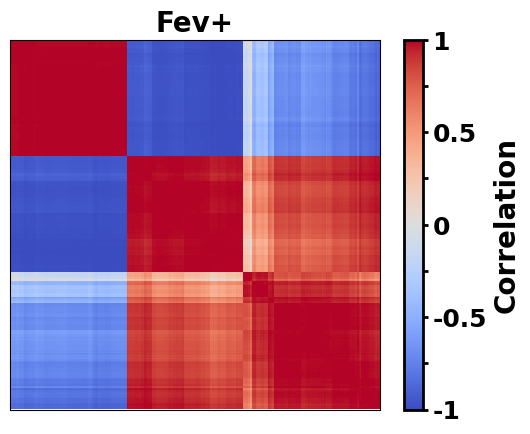

[5 5 5 4 1 5 2 5 5 4 5 1 5 1 5 2 1 2 1 2 2 2 1 1 1 2 5 1 2 1 2 1 1 2 1 5 5
 5 1 5 2 5 5 1 2 2 1 2 5 1 5 3 2 2 4 1 1 5 1 5 1 2 1 5 5 5 1 5 2 2 4 5 2 1
 5 1 1 3 5 2 2 2 2 2 1 1 2 2 1 5 5 2 1 5 1 5 1 1 5 5 1 2 1 1 2 5 2 1 5 2 5
 5 1 4 4 2 2 1 2 2 2 5 2 5 2 5 1 4 5 1 5 4 1 1 2 3 1 4 2 2 1 1 1 5 1 2 1 1
 1 2 5 2 4 1 2 2 4 1 5 5 1 2 1 1 2 2 5 5 4 5 1 2 5 2 5 1 2 2 1 1 2 5 1 1 1
 5 5 1 1 1 5 5 2 1 1 1 1 5 2 2 1 2 5 2 5 2 5 2 5 1 3 5 2 2 2 4 2 4 5 2 1 4
 5 1 2 1 2 1 5 1 2 1 2 2 2 1 2 1 5 2 2 5 1 1 5 5 3 5 1 2 5 2 5 2 2 2 1 5 2
 5 1 5 3 2 1 2 5 5 5 5 2 2 2 1 2 5 5 5 1 2 5 5 2 1 1 5 1 1 1 2 5 5 2 3 2 2
 5 2 4 5 2 5 5 5 2 5 2 2 2 1 2 5 5 1 5 5 2 2 1 5 5 1 2 5 2 5 4 1 1 4 2 1 1
 5 2 5 1 5 2 5 1 2 4 2 1 4 5 4 1 2 2 2 1 3 1 5 2 1 1 2 5 2 2 2 2 3 5 1 1 2
 5 2 1 1 1 2 5 1 4 5 1 5 1 5 4 1 1 2 2 1 1 5 5 1 1 5 1 1 1 5 2 1 5 5 5 1 4
 2 1 3 5 2 1 1 2 1 1 1 2 1 1 5 2 4 2 2 2 2 1 5 2 2 5 2 2 5 1 1 1 1 2 1 2 2
 2 5 5 5 5 5 2 2 1 5 2 1 3 5 5 1 3 1 5 1 2 5 1 2 1 1 4 5 5 5 3 2 1 2 1 2 5
 2 3 5 2 1 1 1 4 1 2 2 2 

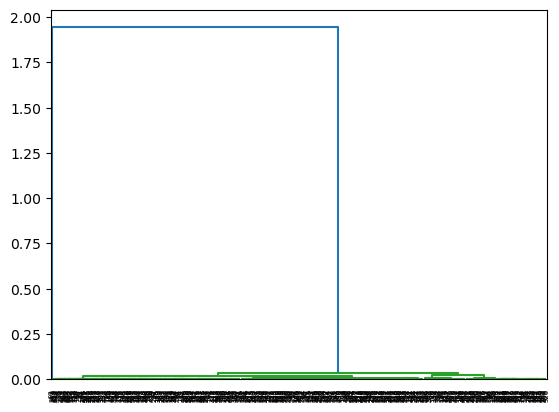

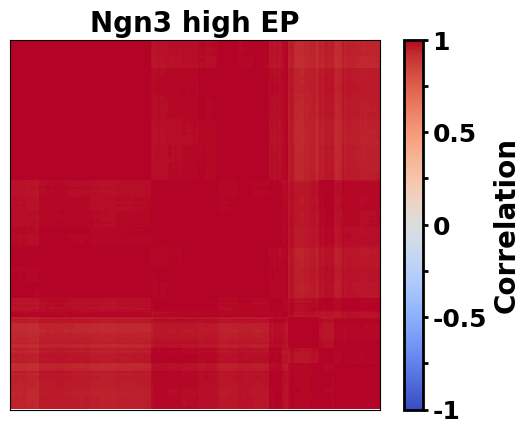

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

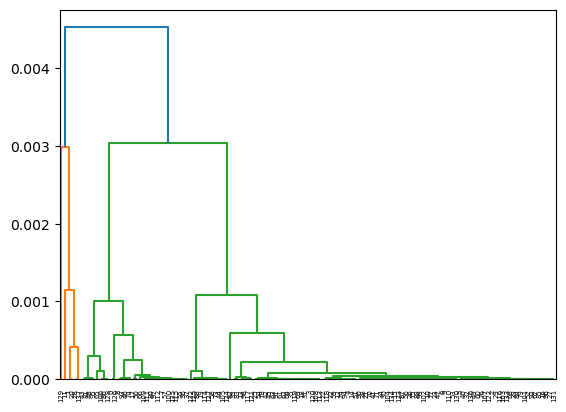

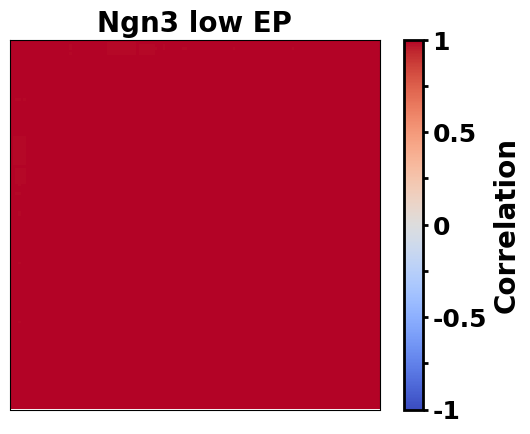

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [28]:
###Before optimize the cosdistance
t = 1 - find_cos_for_prob(X.shape[1], 0.95)
print(X.shape[1],t)
TT = hierarchical_clustering(categories,eigenvec,t,result_path_eigenvec)

In [29]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB ##去官网申请权限
def GRBopt(Eigenvec):
    n = len(Eigenvec)
    np.random.seed(42)
    X = Eigenvec@Eigenvec.T
    # Create model
    m = gp.Model("binary_quadratic")
    m.setParam('Seed', 42)
    # Create binary variables (will be transformed to {-1,1})
    b = m.addVars(n, vtype=GRB.BINARY, name="b")

    # Set objective: min sum_{i,j} c_i c_j x_{ij}
    # where c_i = 2b_i - 1 transforms binary variables to {-1,1}
    obj = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            # Expand (2b_i - 1)(2b_j - 1)x_{ij}
            obj += -4 * X[i,j] * b[i] * b[j]  # quadratic term
            obj += 2 * X[i,j] * b[i]        # linear terms
            obj += 2 * X[i,j] * b[j]
            obj += -X[i,j]                    # constant term

    m.setObjective(obj, GRB.MINIMIZE)

    m.params.TimeLimit = 20*60  # 20 minutes time limit
    # Optimize
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        # Convert binary solution back to {-1,1}
        c = [2 * b[i].x - 1 for i in range(n)]
        print("Optimal solution found:")
        print("c =", c)
        print("Objective value =", m.objVal)
        return c
    else:
        print("No optimal solution found")


In [30]:
eigenvec={}
for i in categories:
    if i == -1:
        eigenvec[i] = Eigenvec[clusters==i]
        continue
    c = GRBopt(Eigenvec[clusters == i])
    if c is None:
        c = [1 for _ in range(Eigenvec[clusters==i].shape[0])]
    eigenvec[i] = np.diag(c)@Eigenvec[clusters==i]

Set parameter LicenseID to value 2632831
Set parameter Seed to value 42
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 9600X 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  1200
Seed  42

Optimize a model with 0 rows, 477 columns and 0 nonzeros
Model fingerprint: 0x8f818fc4
Model has 114003 quadratic objective terms
Variable types: 0 continuous, 477 integer (477 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+03, 2e+03]
  QObjective range [5e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -184616.6368
Found heuristic solution: objective -184616.6368
Found heuristic solution: objective -199368.1755
Presolve time: 0.14s
Presolved: 0 rows, 477 columns, 0 nonzeros
Pr

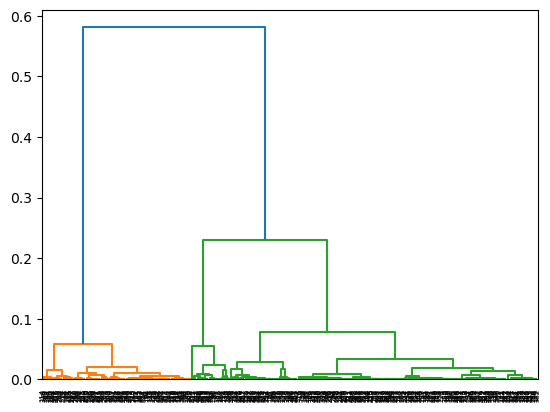

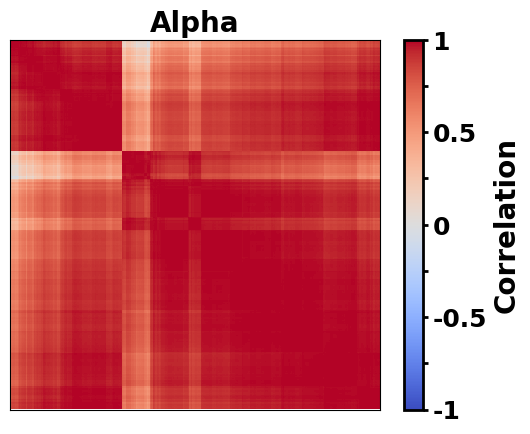

[3 3 3 2 3 3 2 3 1 3 3 3 3 1 3 1 1 3 1 3 1 3 3 3 3 2 3 1 3 3 2 3 3 1 3 3 3
 3 3 2 1 3 3 1 3 3 3 3 3 1 1 3 3 1 3 3 3 1 3 1 3 2 1 3 1 3 3 3 3 3 1 1 1 3
 1 1 1 3 3 3 3 2 2 3 3 3 1 3 1 1 3 1 3 1 1 1 1 1 3 2 1 3 1 3 1 1 3 1 3 3 3
 3 3 3 1 3 1 3 3 1 3 1 2 3 3 1 3 3 3 1 3 1 3 3 3 1 3 3 3 2 3 3 3 3 2 1 1 3
 3 3 3 3 3 2 3 1 3 3 1 3 3 3 3 1 3 1 1 3 3 3 3 3 2 3 3 1 3 3 1 1 1 3 3 1 1
 3 3 3 1 3 3 3 3 3 3 3 2 3 3 3 3 3 2 1 1 3 3 1 3 1 3 1 3 3 2 3 1 1 3 1 3 3
 3 1 3 3 3 3 3 1 3 3 2 3 3 3 3 3 3 1 2 1 3 3 3 1 3 1 1 1 3 3 3 1 3 3 1 3 3
 1 1 3 3 1 1 3 1 3 1 1 1 1 1 3 3 3 3 3 2 3 3 1 1 3 3 3 3 1 3 2 3 1 3 3 3 3
 3 3 3 3 3 3 1 1 1 3 3 3 1 3 3 3 3 2 3 3 3 3 1 1 3 1 2 3 1 3 3 1 3 3 1 3 3
 3 3 1 1 2 3 3 1 3 2 3 3 3 3 3 3 2 3 1 3 3 3 3 1 2 3 3 1 3 1 1 1 3 3 3 3 1
 3 3 3 3 1 3 3 1 3 1 1 2 3 1 1 3 3 3 1 3 1 2 1 3 3 3 2 1 3 3 1 3 3 3 1 3 3
 1 3 3 1 2 2 3 1 3 3 3 1 3 2 3 3 3 3 1 1 3 2 2 3 3 3 3 3 1 3 1 1 3 3 1 3 1
 1 3 1 3 3 3 3 3 3 3 3 2 2 1 3 1 1 1 3 3 3 3 3 3 3 3 3 1 3 1 1 3 1]


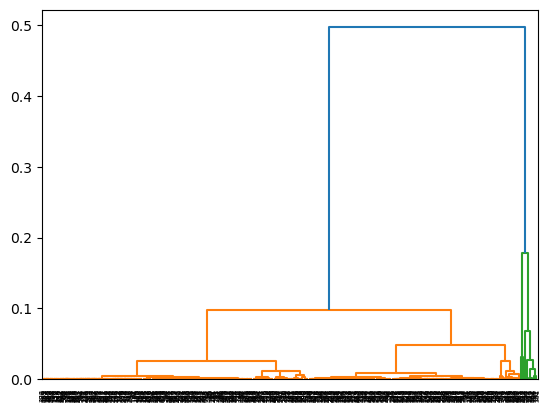

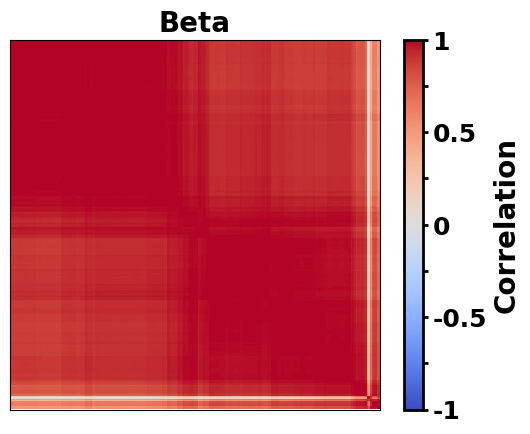

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

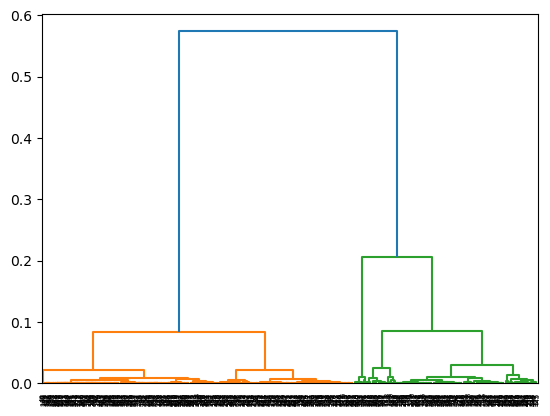

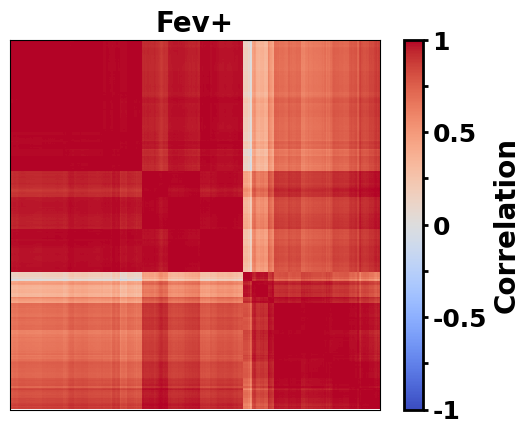

[3 3 3 3 1 3 1 3 3 3 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 3
 3 1 3 1 3 3 1 1 1 1 1 3 1 3 2 1 1 3 1 1 3 1 3 1 1 1 3 3 3 1 3 1 1 3 3 1 1
 3 1 1 2 3 1 1 1 1 1 1 1 1 1 1 3 3 1 1 3 1 3 1 1 3 3 1 1 1 1 1 3 1 1 3 1 3
 3 1 3 3 1 1 1 1 1 1 3 1 3 1 3 1 3 3 1 3 3 1 1 1 2 1 3 1 1 1 1 1 3 1 1 1 1
 1 1 3 1 3 1 1 1 3 1 3 3 1 1 1 1 1 1 3 3 3 3 1 1 3 1 3 1 1 1 1 1 1 3 1 1 1
 3 3 1 1 1 3 3 1 1 1 1 1 3 1 1 1 1 3 1 3 1 3 1 3 1 2 3 1 1 1 3 1 3 3 1 1 3
 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 3 1 1 3 3 2 3 1 1 3 1 3 1 1 1 1 3 1
 3 1 3 2 1 1 1 3 3 3 3 1 1 1 1 1 3 3 3 1 1 3 3 1 1 1 3 1 1 1 1 3 3 1 2 1 1
 3 1 3 3 1 3 3 3 1 3 1 1 1 1 1 3 3 1 3 3 1 1 1 3 3 1 1 3 1 3 3 1 1 3 1 1 1
 3 1 3 1 3 1 3 1 1 3 1 1 3 3 3 1 1 1 1 1 2 1 3 1 1 1 1 3 1 1 1 1 2 3 1 1 1
 3 1 1 1 1 1 3 1 3 3 1 3 1 3 3 1 1 1 1 1 1 3 3 1 1 3 1 1 1 3 1 1 3 3 3 1 3
 1 1 2 3 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 3 1 1 3 1 1 3 1 1 1 1 1 1 1 1
 1 3 3 3 3 3 1 1 1 3 1 1 2 3 3 1 2 1 3 1 1 3 1 1 1 1 3 3 3 3 2 1 1 1 1 1 3
 1 2 3 1 1 1 1 3 1 1 1 1 

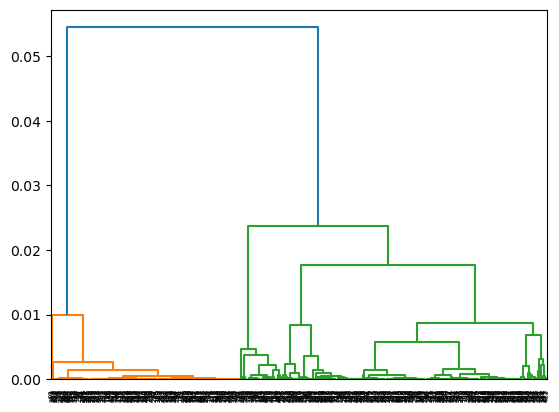

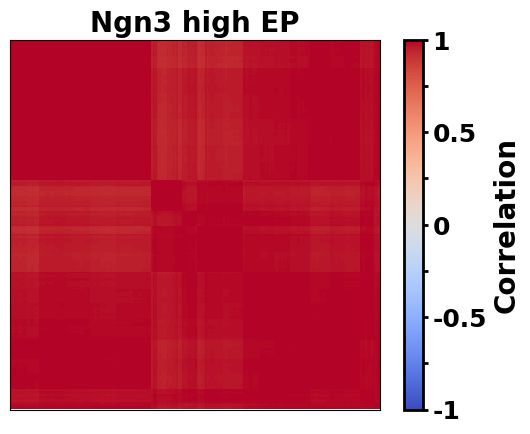

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

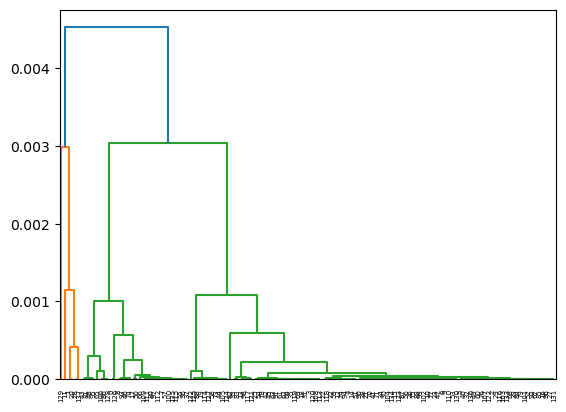

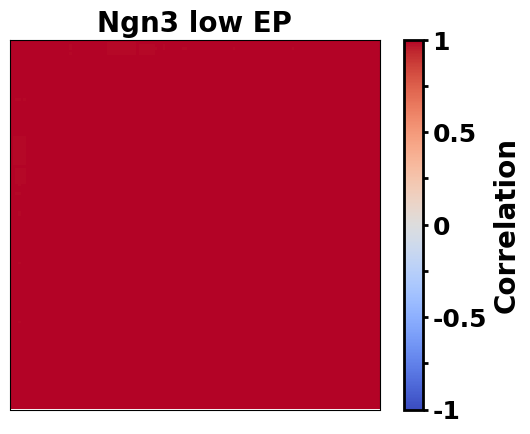

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [31]:
###After optimize the cosdistance. cluster threshold is t
# t = 1 - np.cos(np.pi/8)#threshold                    自行选择
# t = 1 - 1.9/2#threshold                    自行选择
## 即 阈值的选取为30度以内或者按照随机向量的95%分位数
t_new = max(t,1-np.cos(np.pi/6))
TT = hierarchical_clustering(categories,eigenvec,t_new,result_path_eigenvec,save_name='Corr_new')


In [32]:
result_path_eigenvec

'results/EG_ab_bin/Adjacency/k_nei=10/K=3 L=6/eigengene_Eigenvec/'

In [33]:
for i in categories:
    TT[i] = my_Rearrange(TT[i])


cluster number of Alpha 3
num of 1 type in Alpha: 296
num of 2 type in Alpha: 144
num of 3 type in Alpha: 37

cluster number of Beta 3
num of 1 type in Beta: 571
num of 2 type in Beta: 16
num of 3 type in Beta: 4

cluster number of Fev+ 3
num of 1 type in Fev+: 369
num of 2 type in Fev+: 203
num of 3 type in Fev+: 15

cluster number of Ngn3 high EP 1
num of 1 type in Ngn3 high EP: 529

cluster number of Ngn3 low EP 1
num of 1 type in Ngn3 low EP: 138


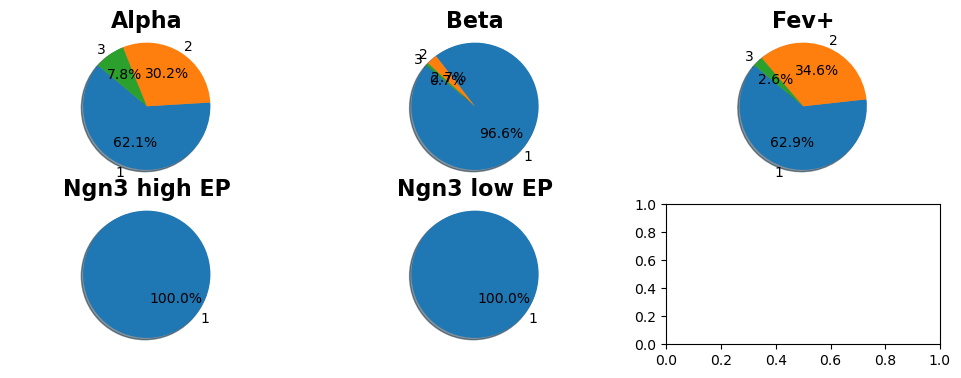

In [34]:
##聚类结果的饼图显示
nc = len(categories)
row = int(np.sqrt(nc))
col = nc // row + 1
fig, axs = plt.subplots(row, col,figsize = (12,4))
k = 0
for i in categories:
    if i == 'Other Glia' or i == -1:
        continue
    print('')
    print(f'cluster number of {i}',len(set(TT[i])))
    for j in set(TT[i]):
        print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
    axs[k//col,k%col].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
    axs[k//col,k%col].axis('equal')  # 确保饼图是圆形的
    axs[k//col,k%col].set_title(f'{i}',fontsize=16,weight='bold')
    k+=1
# plt.title('Clustering of eigenvectors on different cell',fontsize=20,weight='bold')
plt.savefig(result_path_eigenvec+f'pie_eigenvector{t}.png')
plt.show()


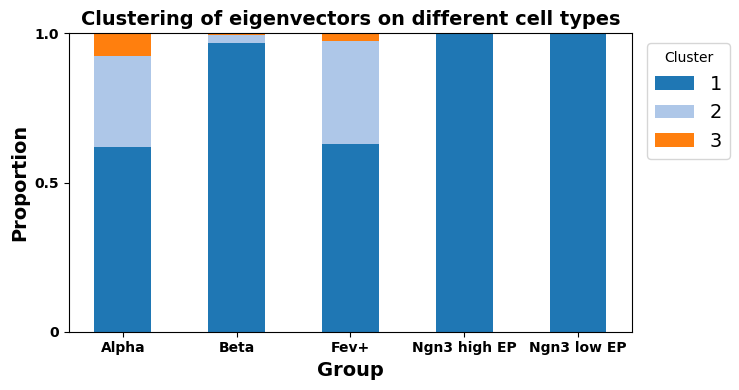

In [35]:
# 统计各组类别数量
group_names = []  # 保存组名
class_names = set()  # 所有出现过的类别
group_class_count = {}

for i in categories:
    if i == -1:
        continue
    group_names.append(f"{i}")
    values, counts = np.unique(TT[i], return_counts=True)
    group_class_count[i] = dict(zip(values, counts))
    class_names.update(values)

class_names = sorted(list(class_names))

# 构造比例矩阵
count_matrix = []
for i in categories:
    if i == -1:
        continue
    total = sum(group_class_count[i].get(j, 0) for j in class_names)
    # 转为比例
    row = [group_class_count[i].get(j, 0) / total if total > 0 else 0 for j in class_names]
    count_matrix.append(row)

count_matrix = np.array(count_matrix)  # shape: n_groups × n_classes

# 绘制100%堆叠柱状图
fig, ax = plt.subplots(figsize=(len(group_names)*1.5, 4))

bottom = np.zeros(len(group_names))
colors = plt.cm.tab20.colors  # 配色，可改
for idx, cname in enumerate(class_names):
    vals = count_matrix[:, idx]
    ax.bar(group_names, vals, width=0.5,bottom=bottom, label=str(cname), color=colors[idx % len(colors)])
    bottom += vals


ax.set_ylabel("Proportion",fontsize=14, weight='bold')
ax.set_yticklabels([0,0.5,1.0],fontsize=10,weight='bold')
ax.set_xticklabels(categories,fontsize=10,weight='bold')
yticks = np.arange(0, 1.1, 0.5)
ax.set_yticks(yticks)
ax.set_xlabel("Group",fontsize=14,weight='bold')
ax.set_title(f"Clustering of eigenvectors on different cell types", fontsize=14, weight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left',fontsize=14)
plt.tight_layout()
plt.savefig(result_path_eigenvec+f'bar_eigenvector{t}.png')
plt.show()

['#FF5733' '#FFBD33' '#FFC300' '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF'
 '#337BFF' '#335BFF' '#5733FF' '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B'
 '#FF5733' '#FF8D33' '#FF3333' '#FF6633' '#FF9933' '#FFFF33' '#BFFF33'
 '#33FF8D' '#33FF99' '#33FFFF' '#3399FF' '#3366FF' '#6633FF' '#9933FF'
 '#FF33C4' '#FF33A1' '#FF5733' '#FF8D33' '#FF5733' '#FFBD33' '#FFC300'
 '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF' '#337BFF' '#335BFF' '#5733FF'
 '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B' '#FF5733' '#FF8D33' '#FF3333'
 '#FF6633' '#FF9933' '#FFFF33' '#BFFF33' '#33FF8D' '#33FF99' '#33FFFF'
 '#3399FF' '#3366FF' '#6633FF' '#9933FF' '#FF33C4' '#FF33A1' '#FF5733'
 '#FF8D33']


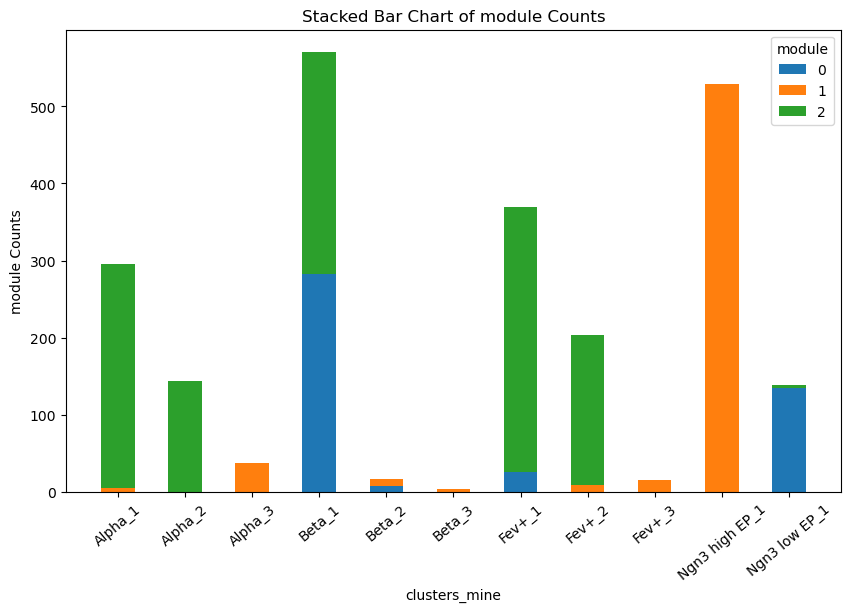

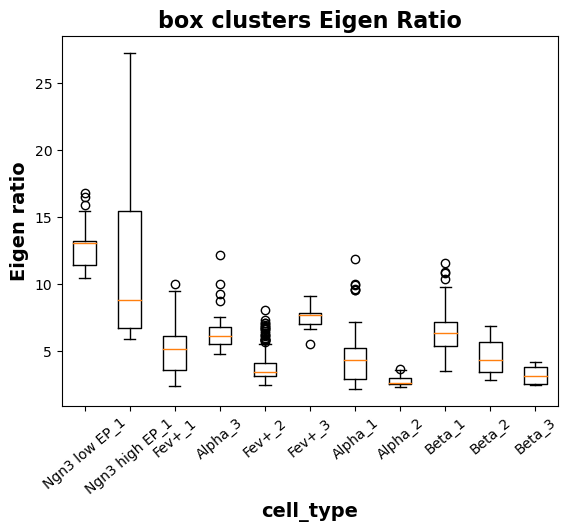

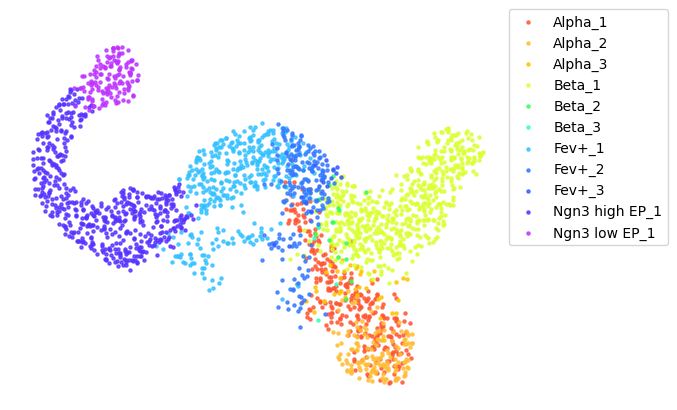

In [36]:

clusters_mine = []
ktime = {}
for k,i in enumerate(clusters):
    if i in ktime:
        ktime[i] = ktime[i]+1
    else:
        ktime[i] = 0
    clusters_mine.append(f'{i}_{TT[i][ktime[i]]}')
clusters_mine = np.array(clusters_mine)
eigenvec_mine = {}
for i in categories:
    for j in TT[i]:
        eigenvec_mine[f'{i}_{j}'] = eigenvec[i][TT[i] == j]

colors_hex = [
    "#FF5733", "#FFBD33", "#FFC300", "#DAFF33", "#33FF57", 
    "#33FFBD", "#33C1FF", "#337BFF", "#335BFF", "#5733FF", 
    "#BD33FF", "#FF33F6", "#FF33A1", "#FF335B", "#FF5733", 
    "#FF8D33", "#FF3333", "#FF6633", "#FF9933", "#FFFF33", 
    "#BFFF33", "#33FF8D", "#33FF99", "#33FFFF", "#3399FF", 
    "#3366FF", "#6633FF", "#9933FF", "#FF33C4", "#FF33A1", 
    "#FF5733", "#FF8D33"
]

# 转换为NumPy数组
colors_np = np.array(colors_hex)
colors_np = np.hstack((colors_np,colors_np))
# 打印结果
print(colors_np)

data = {}
for i in np.unique(clusters_mine):
    data[i] = np.argmax(eigenvec_mine[i],axis=1)

# 统计每组中不同元素的个数
labels = list(data.keys())
element_counts = {}
for group, elements in data.items():
    unique, counts = np.unique(elements, return_counts=True)
    element_counts[group] = dict(zip(unique, counts))

# 转换为DataFrame格式以便绘图
elements = list(set().union(*[set(v.keys()) for v in element_counts.values()]))
counts_matrix = np.zeros((len(labels), len(elements)))

for i, group in enumerate(labels):
    for j, element in enumerate(elements):
        counts_matrix[i, j] = element_counts[group].get(element, 0)

# 绘制堆叠柱状图
plt.figure(figsize=(10, 6))
bar_width = 0.5
bottoms = np.zeros(len(labels))

# 绘制每个元素的堆叠柱
for j in range(len(elements)):
    plt.bar(labels, counts_matrix[:, j], width=bar_width, bottom=bottoms, label=elements[j])
    bottoms += counts_matrix[:, j]

plt.xticks(rotation=40)
# 添加标签和图例
plt.xlabel('clusters_mine')
plt.ylabel('module Counts')
plt.title('Stacked Bar Chart of module Counts')
plt.legend(title='module')
plt.show()

PLT_box(clusters_mine,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path_eigenvec+f'box Eigen Ratio {new_para_name}_mine'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=cell_vpt)
np.random.seed(42)
for k,i in enumerate(np.unique(clusters_mine)):
    plt.scatter(X_plt[clusters_mine==i],Y_plt[clusters_mine==i], s= 5,c = colors_np[k],alpha=0.8,
                cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#     plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
#                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
#                scale=0.3)
# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'clusters_mine.png',bbox_inches='tight')
plt.show()

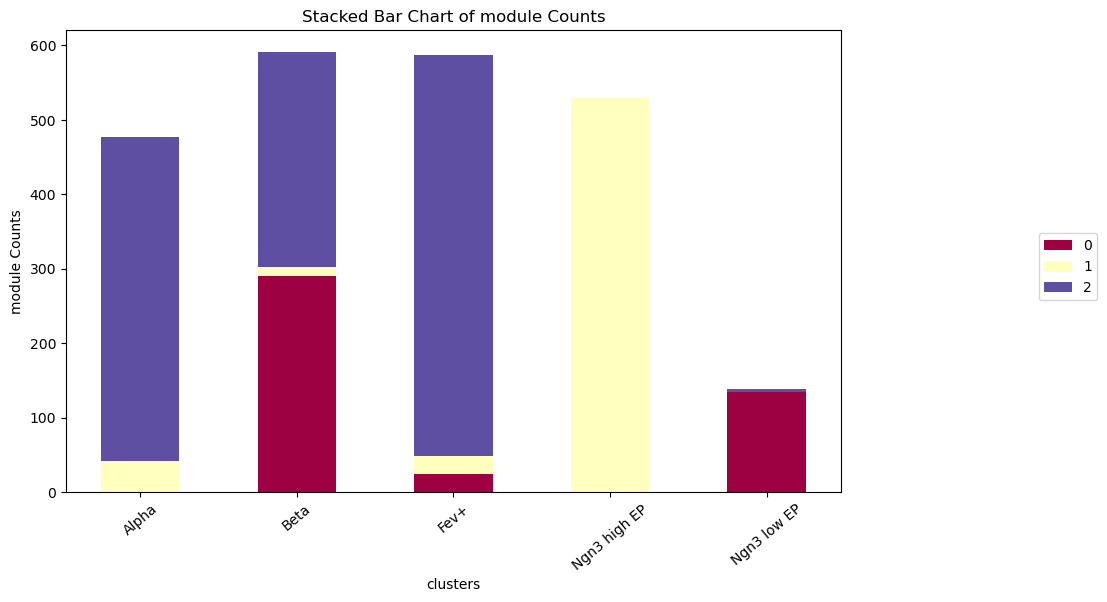

In [37]:
######cluster_mine
data = {}
for i in np.unique(clusters):
    data[i] = np.argmax(eigenvec[i],axis=1)
# 统计每组中不同元素的个数
labels = list(data.keys())
element_counts = {}
for group, elements in data.items():
    unique, counts = np.unique(elements, return_counts=True)
    element_counts[group] = dict(zip(unique, counts))

# 转换为DataFrame格式以便绘图
elements = list(set().union(*[set(v.keys()) for v in element_counts.values()]))
counts_matrix = np.zeros((len(labels), len(elements)))

for i, group in enumerate(labels):
    if group == -1:
        continue
    for j, element in enumerate(elements):
        counts_matrix[i, j] = element_counts[group].get(element, 0)

# 绘制堆叠柱状图
plt.figure(figsize=(10, 6))
bar_width = 0.5
bottoms = np.zeros(len(labels))
color_stackedbar = plt.get_cmap('Spectral')(np.linspace(0, 1, len(elements))) 
# 绘制每个元素的堆叠柱
for j in range(len(elements)):
    plt.bar(labels, counts_matrix[:, j], width=bar_width, bottom=bottoms, label=elements[j],color=color_stackedbar[j])
    bottoms += counts_matrix[:, j]

plt.xticks(rotation=40)
# 添加标签和图例
plt.xlabel('clusters')
plt.ylabel('module Counts')
plt.title('Stacked Bar Chart of module Counts')
plt.legend(title='module')
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.savefig(result_path_eigenvec+f'stack bar of coordinate',dpi=300, bbox_inches='tight')
plt.show()

plot the new vector

In [38]:
sonnodes = {'Ngn3 low EP': ['Ngn3 high EP'],
            'Ngn3 high EP': ['Fev+'],
            'Fev+': ['Beta','Alpha'],
            'Alpha': [],
            'Beta': []}
eigenvec = adjust_eigenvec_direction(eigenvec,sonnodes,clusters,X)

In [39]:
##移动之后的新向量，保存方法是字典
# colors = plt.get_cmap('Spectral')(np.linspace(0, 1, len(categories)))
colors = colors_np
newvec={}
startvec={}
color_cl = {}
k=0
for i in categories:
    newvec[i] ,startvec[i] = [],[]
    color_cl[i] = colors[k*2]
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
        startvec[i].append(cell_i)

##聚类颜色
color_cell = []
for i in range(len(X)):
    color_cell.append(color_cl[clusters[i]])

0 2 1


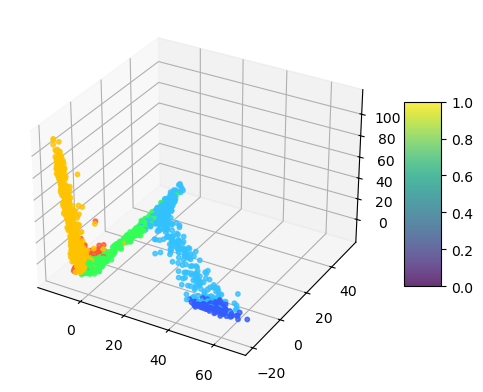

In [40]:
if X.shape[1]>2:
    max1,max2,max3 = np.argsort(np.mean(X**2,axis=0))[-3:]
    print(max1,max2,max3)
    plot3d(X[:,max1], X[:,max2], X[:,max3],
       color=color_cell,color_bar_name='',save_name=result_path + f'cl on {new_para_name}{K}_{L}.png')

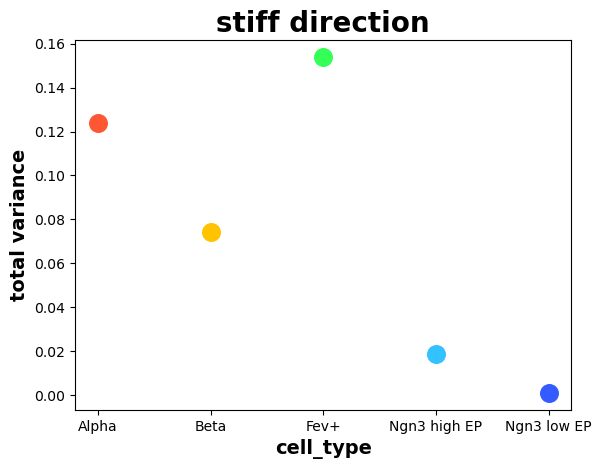

In [61]:
#variance of parameter velocity
k=0
if 'Other Glia' in categories:
    categories_new=np.delete(categories, np.where(categories == 'Other Glia'))
elif -1 in categories:
    categories_new=np.delete(categories, np.where(categories == -1))
else:
    categories_new = categories
for i in categories_new:
    # vec_corr = eigenvec[i]@eigenvec[i].T
    # plt.scatter(k,np.trace(vec_corr),label=i,s=10)
    plt.scatter(k,np.sum(np.var(eigenvec[i],axis=0)),label=i,s=160,c=color_cl[i])
    k+=1
plt.title('stiff direction', fontsize=20,weight='bold')
plt.xticks(range(len(categories_new)),categories_new)
if np.sum([len(str(i)) for i in categories_new])>50:
    plt.xticks(rotation=40)
# plt.legend()

plt.xlabel('cell_type',fontsize=14,weight='bold')
plt.ylabel("total variance",fontsize=14,weight='bold')
plt.savefig(result_path_eigenvec+f'variance of eigenvec',dpi=300, bbox_inches='tight')
plt.show()

In [42]:
for i in categories:
    print(i,np.mean(X[clusters==i],axis=0),np.var(X[clusters==i],axis=0))

Alpha [-8.275455 -8.763677 -9.129974] [ 1.2722723  7.6981387 14.058883 ]
Beta [ -9.318201  25.390049 -15.030804] [   4.6604366 1159.3064       8.004292 ]
Fev+ [-4.2523794 -9.905796   2.2383575] [  2.6280427   2.0567665 243.87234  ]
Ngn3 high EP [ 8.774778  -7.5772543 26.148268 ] [3.1722205e+02 2.5933266e-01 2.9616812e+02]
Ngn3 low EP [ 52.961857   -7.2621737 -13.8271265] [20.543215    0.04607054  2.8059704 ]


In [43]:
####cluster内整体正负号调整
newvec={}
k=0
for i in categories:
    newvec[i]  = []
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
    newvec[i] = np.array(newvec[i])

Epoch:9, train_loss:9.426392, val_loss:9.543403, lr:0.00100
Epoch:19, train_loss:6.361155, val_loss:6.288966, lr:0.00100
Epoch:29, train_loss:5.401703, val_loss:5.152910, lr:0.00100
Epoch:39, train_loss:4.554817, val_loss:4.459481, lr:0.00100
Epoch:49, train_loss:3.905350, val_loss:3.807589, lr:0.00100
Epoch:59, train_loss:3.387691, val_loss:3.317028, lr:0.00100
Epoch:69, train_loss:2.976129, val_loss:2.942926, lr:0.00100
Epoch:79, train_loss:2.662946, val_loss:2.630618, lr:0.00100
Epoch:89, train_loss:2.454285, val_loss:2.433915, lr:0.00100
Epoch:99, train_loss:2.337904, val_loss:2.328595, lr:0.00100
Epoch:109, train_loss:2.271966, val_loss:2.267456, lr:0.00100
Epoch:119, train_loss:2.227932, val_loss:2.227989, lr:0.00100
Epoch:129, train_loss:2.194360, val_loss:2.202117, lr:0.00100
Epoch:139, train_loss:2.167078, val_loss:2.180818, lr:0.00100
Epoch:149, train_loss:2.145118, val_loss:2.164867, lr:0.00100
Epoch:159, train_loss:2.126006, val_loss:2.151973, lr:0.00100
Epoch:169, train_lo

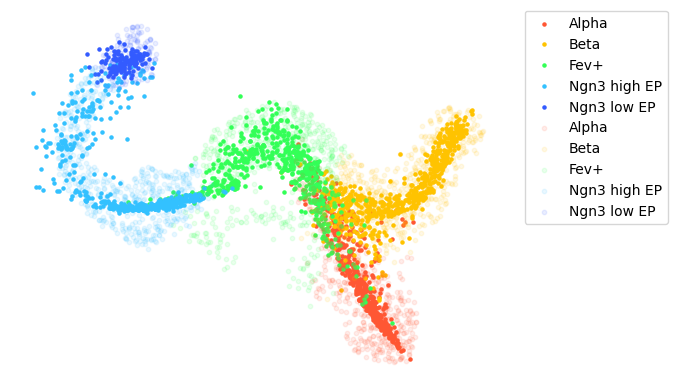

In [44]:

# 1. 模型定义
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2),
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 推荐自动学习率衰减调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# vstack保证Y_plt是N,2
XY_plt = np.vstack((X_plt,Y_plt)).T

# split data
train_idx, test_idx = train_test_split(X.shape[0], train_ratio=0.7)
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = XY_plt[train_idx], XY_plt[test_idx]

patience = 200  # 更稳健一点的early stopping
best_loss = float('inf')
counter = 0
max_epochs = 300

epoch = 0
while epoch < max_epochs:
    # train
    model.train()
    x_in = torch.tensor(X_train.astype(np.float32))
    x_out = torch.tensor(Y_train.astype(np.float32))
    output = model(x_in)
    train_loss = loss_fn(output, x_out)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # eval
    model.eval()
    with torch.no_grad():
        test_in = torch.tensor(X_test.astype(np.float32))
        test_out = model(test_in)
        val_loss = loss_fn(test_out, torch.tensor(Y_test.astype(np.float32)))

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_loss - 1e-6:   # 增加一个最小改善阈值，避免浮点误差反复
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}, best val loss: {best_loss.item():.6f}")
        break

    if epoch % 10 == 9:
        print(f"Epoch:{epoch}, train_loss:{train_loss.item():.6f}, val_loss:{val_loss.item():.6f}, lr:{optimizer.param_groups[0]['lr']:.5f}")
    epoch += 1

###
np.random.seed(42)
for k,i in enumerate(np.unique(clusters)):
    sub_XY_plt = model(torch.tensor(X[clusters==i])).detach().numpy()
    
    plt.scatter(sub_XY_plt[:,0],sub_XY_plt[:,1], s= 5,c = colors_np[k*2],alpha=1,
                cmap='Spectral',label=f'{i}')
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 10,c = color_cl[i],alpha=0.1,
                cmap='Spectral',label=f'{i}')
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
# plt.savefig(result_path_eigenvec+'clusters_eigenvec.png',bbox_inches='tight')
plt.show()



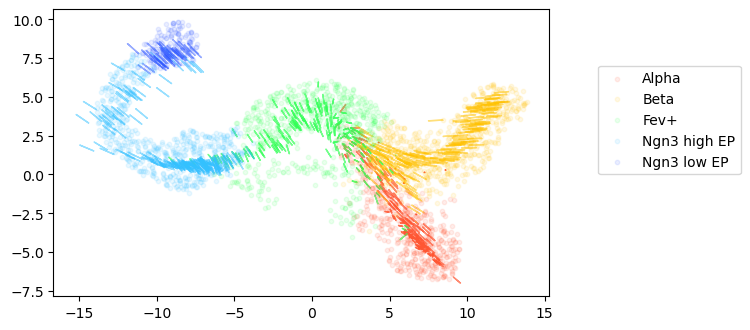

In [63]:
##箭头图
eta = 1e-2
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    # start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eta*eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
            continue
        ### 一定概率显示箭头
        if np.random.rand() > 0.3:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                  label=f'{i}' if j==0 else None)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 10,c = color_cl[i],alpha=0.1,
                cmap='Spectral',label=f'{i}')
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
plt.show()

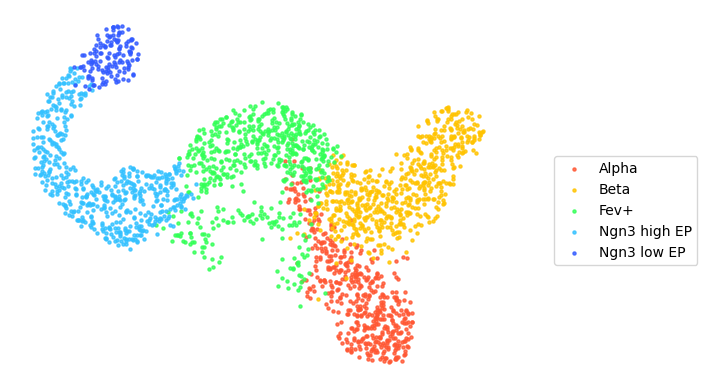

In [46]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.legend(bbox_to_anchor=(1.4,0.29),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'TSNE_eigenvector.png',bbox_inches='tight')
plt.show()

In [47]:
# ## 在cluster平均点画箭头

# np.random.seed(42)
# for i in categories:
#     plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
#                 cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     for j in range(len(set(TT[i]))):
#         if np.sum(TT[i]==list(set(TT[i]))[j])/len(TT[i])<0.01:
#             continue
#         lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i]==list(set(TT[i]))[j])*len(TT[i])
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#         plt.arrow(start_embedding[j, 0], start_embedding[j, 1],
#                 (test_embedding[j, 0] - start_embedding[j, 0])/lenvecj*2,
#                 (test_embedding[j, 1] - start_embedding[j, 1])/lenvecj*2,width=0.2)
# plt.title('stiff direction on Umap', fontsize=24,weight='bold')
# plt.gca().set_aspect('equal')
# plt.axis('off')
# plt.legend(bbox_to_anchor=(2,0.29),loc='lower right')
# # plt.savefig(result_path+'TSNE_eigenvector.png')
# plt.show()

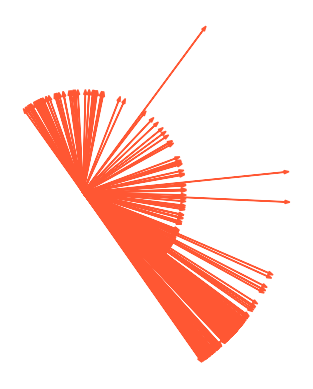

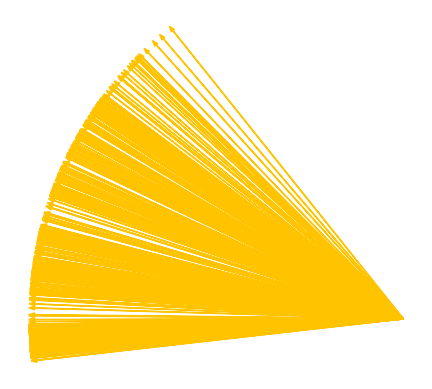

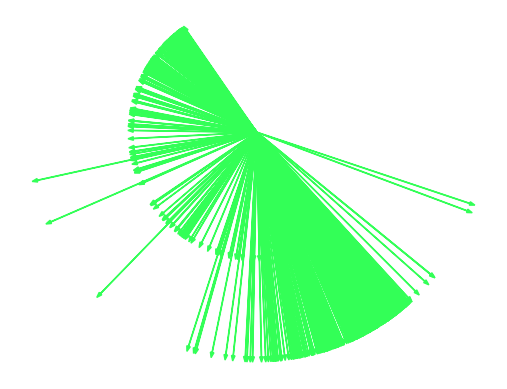

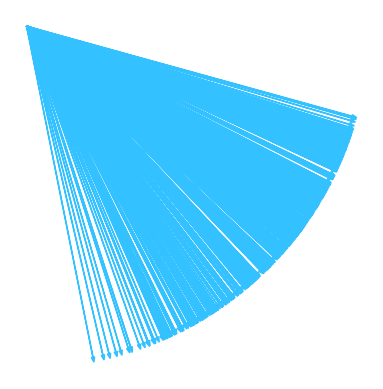

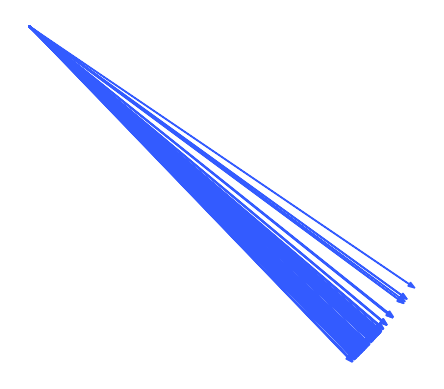

In [62]:
#####神经网络得到可视化的箭头
eta = 1
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    # start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eta*eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.05:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],head_width=0.01,
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.savefig(result_path_eigenvec+f'arrow of {i}.png')
    plt.show()

In [49]:
DAG,clusters_eigenvec = flow_analyze(sonnodes,eigenvec,clusters,X)

In [50]:
nodes = DAG['nodes']
edges = DAG['edges']
node_size = DAG['node_size']
weight = DAG['weight']
weighted_edges = [(i[0], i[1], round(weight[i],4)) for i in weight]

In [51]:
def get_layers(sonnodes,start_node):
    layers = {}
    visited = set()
    def dfs(node, layer):
        if node in visited:
            return
        visited.add(node)
        if layer not in layers:
            layers[layer] = []
        layers[layer].append(node)
        for child in sonnodes.get(node, []):
            dfs(child, layer + 1)
    dfs(start_node, 0)
    return layers

True


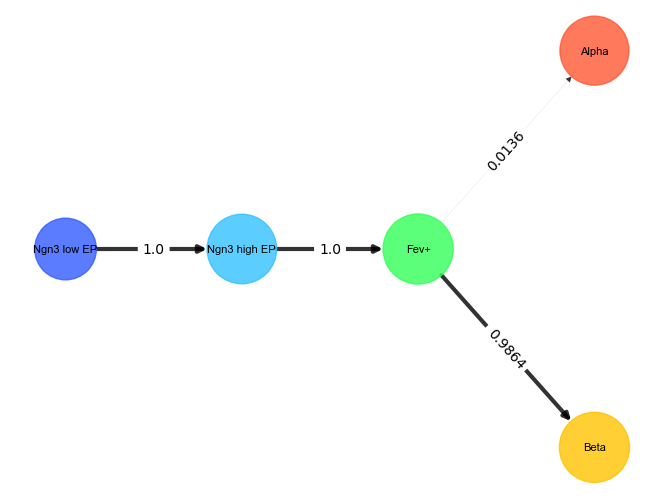

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()
G.add_nodes_from(nodes)  # 举例
G.add_weighted_edges_from(weighted_edges)  # 举例

# 检查是否是DAG
print(nx.is_directed_acyclic_graph(G))  # 若非DAG会返回False
# pos = nx.spring_layout(G)  # 节点布局策略
# 获取拓扑排序作为分层布局
layers = get_layers(sonnodes,'Ngn3 low EP')
pos = nx.multipartite_layout(G,subset_key=layers)
weights = [G[u][v]['weight']*3 for u, v in G.edges()]
sizes = [400*np.log(i) for i in node_size]
node_colors = [color_cl[i] for i in nodes]
# 绘图
nx.draw(G, pos, width=weights, arrows=True,node_size=sizes,node_color=node_colors,alpha=0.8)
nx.draw_networkx_labels(
    G, pos,
    font_size=8,      # 字体大小
    font_color="black",# 颜色
    font_family="Arial"
)

# 标签为权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.savefig(result_path+'DAG_eigenvector.png',dpi=300, bbox_inches='tight')
plt.show()

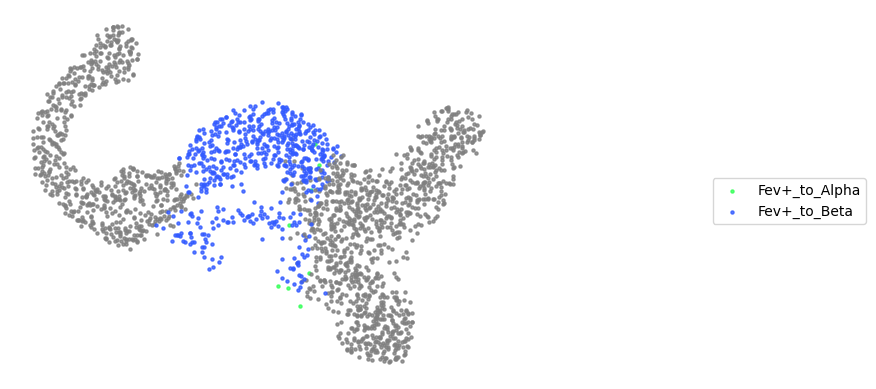

'eigengene'

In [53]:
np.random.seed(42)
for k,i in enumerate(set(clusters_eigenvec)):
    if '_to_' not in i:
        plt.scatter(X_plt[clusters_eigenvec==i],Y_plt[clusters_eigenvec==i], s= 5,c = 'grey',alpha=0.8,
                cmap='Spectral')
        continue
    plt.scatter(X_plt[clusters_eigenvec==i],Y_plt[clusters_eigenvec==i], s= 5,c = colors_np[k*2],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.legend(bbox_to_anchor=(1.74,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'clusters_eigenvec_to.png',bbox_inches='tight')
plt.show()
new_para_name

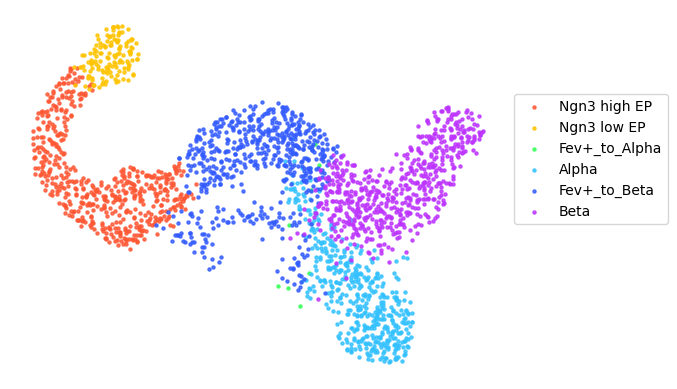

In [54]:
np.random.seed(42)
for k,i in enumerate(set(clusters_eigenvec)):
    plt.scatter(X_plt[clusters_eigenvec==i],Y_plt[clusters_eigenvec==i], s= 5,c = colors_np[k*2],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'clusters_eigenvec.png',bbox_inches='tight')
plt.show()

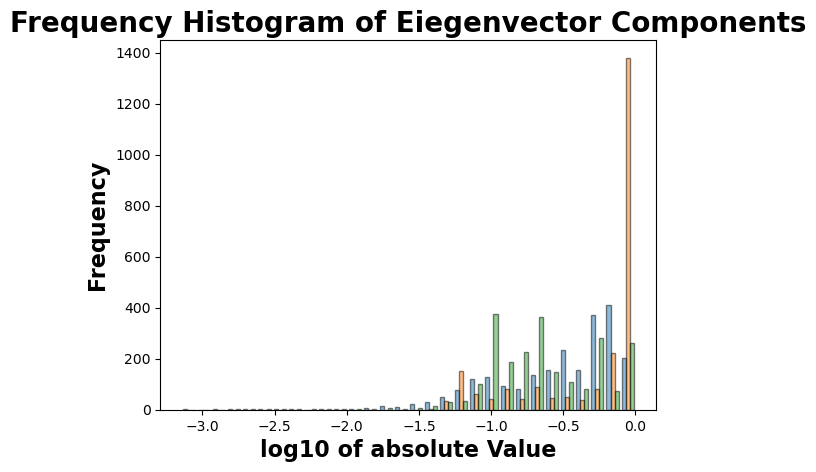

In [55]:
plt.hist(np.log10(Eigenvec**2)/2, bins=30, alpha=0.5, edgecolor='black', label='Frequency Histogram')
# 添加标题和标签
plt.title('Frequency Histogram of Eiegenvector Components', fontsize=20,weight='bold')
plt.xlabel('log10 of absolute Value', fontsize=16,weight='bold')
plt.ylabel('Frequency', fontsize=16,weight='bold')
plt.savefig(result_path_eigenvec+'Frequency of Eigenvec.png',bbox_inches='tight')
# plt.legend()



In [56]:
###
# tf_stiffnum = np.zeros(X.shape[0])
pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
Eigenvec2 = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
for i in range(X.shape[0]):
    pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
    FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
    Eigenvec2[i] = np.linalg.eigh(FIgene_i)[1][:,-2]


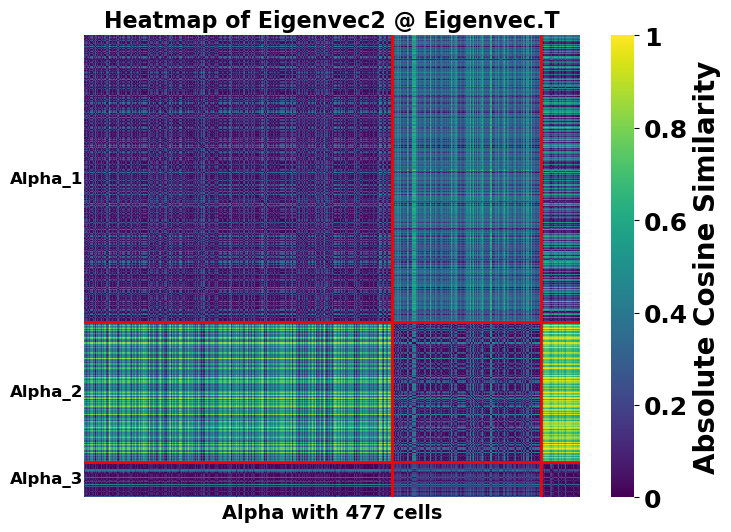

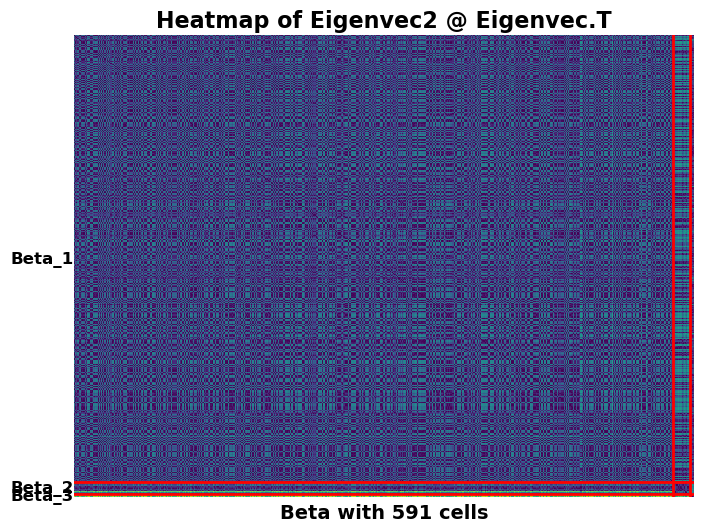

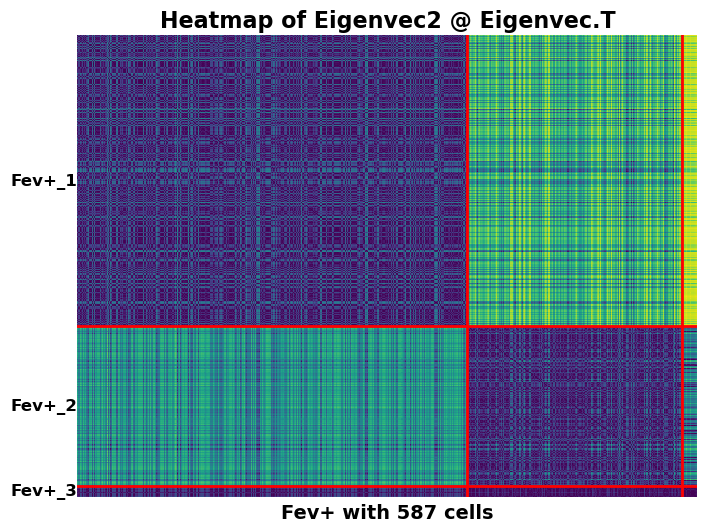

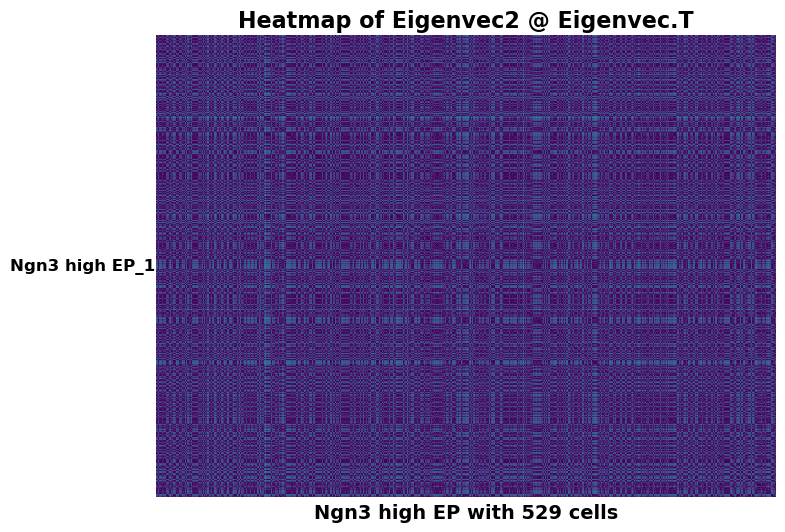

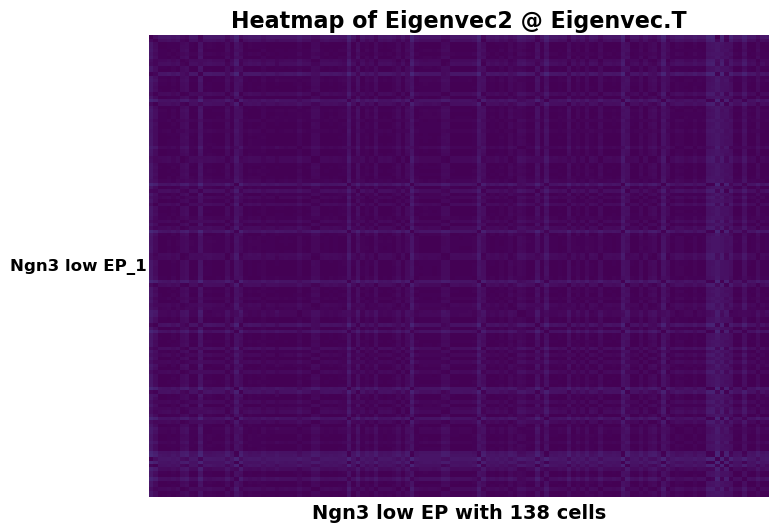

In [57]:
k=0
for cells in categories:
    a = []
    b = []
    group_sizes = []
    part_names = []
    for spilit_cells in np.unique(clusters_mine):
        if cells not in spilit_cells:
            continue
        a_group = Eigenvec[clusters_mine==spilit_cells]
        b_group = Eigenvec2[clusters_mine==spilit_cells]
        a.append(a_group)
        b.append(b_group)
        group_sizes.append(len(b_group))
        part_names.append(str(spilit_cells))
    a = np.vstack(a)
    b = np.vstack(b)
    c = b @ a.T

    boundaries = np.cumsum(group_sizes)
    y_lines = boundaries[:-1]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(np.abs(c), cmap='viridis', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Heatmap of Eigenvec2 @ Eigenvec.T', fontsize=16, weight='bold')
    plt.xlabel(f'{cells} with {np.sum(clusters==cells)} cells', fontsize=14, weight='bold')
    if k == 0:
        cb = ax.collections[0].colorbar
        for tick in cb.ax.get_yticklabels():
            tick.set_fontsize(18)  # 设置刻度标签字体大小
            tick.set_weight('bold')  # 设置刻度标签加粗    
        cb.set_label('Absolute Cosine Similarity', fontsize=20, weight='bold')
        cb.set_ticklabels(['0','0.2','0.4','0.6', '0.8','1'])  # 设置刻度标签
        k+=1
    else:
        ax.collections[0].colorbar.remove()
    # 画分界线
    for y in y_lines:
        ax.axhline(y, color='red', lw=2)
    for x in y_lines:
        ax.axvline(x, color='red', lw=2)
    # 标注文字
    y_start = 0
    for size, name in zip(group_sizes, part_names):
        y_center = y_start + size / 2
        ax.text(-0.5, y_center, name, va='center', ha='right', fontsize=12, color='black', weight='bold')
        y_start += size
    plt.savefig(result_path_eigenvec+f'Heatmap of Eigenvec2 @ Eigenvec.T {cells}.png', bbox_inches='tight')
    plt.show()

In [58]:
hue_order = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta', 'Alpha']

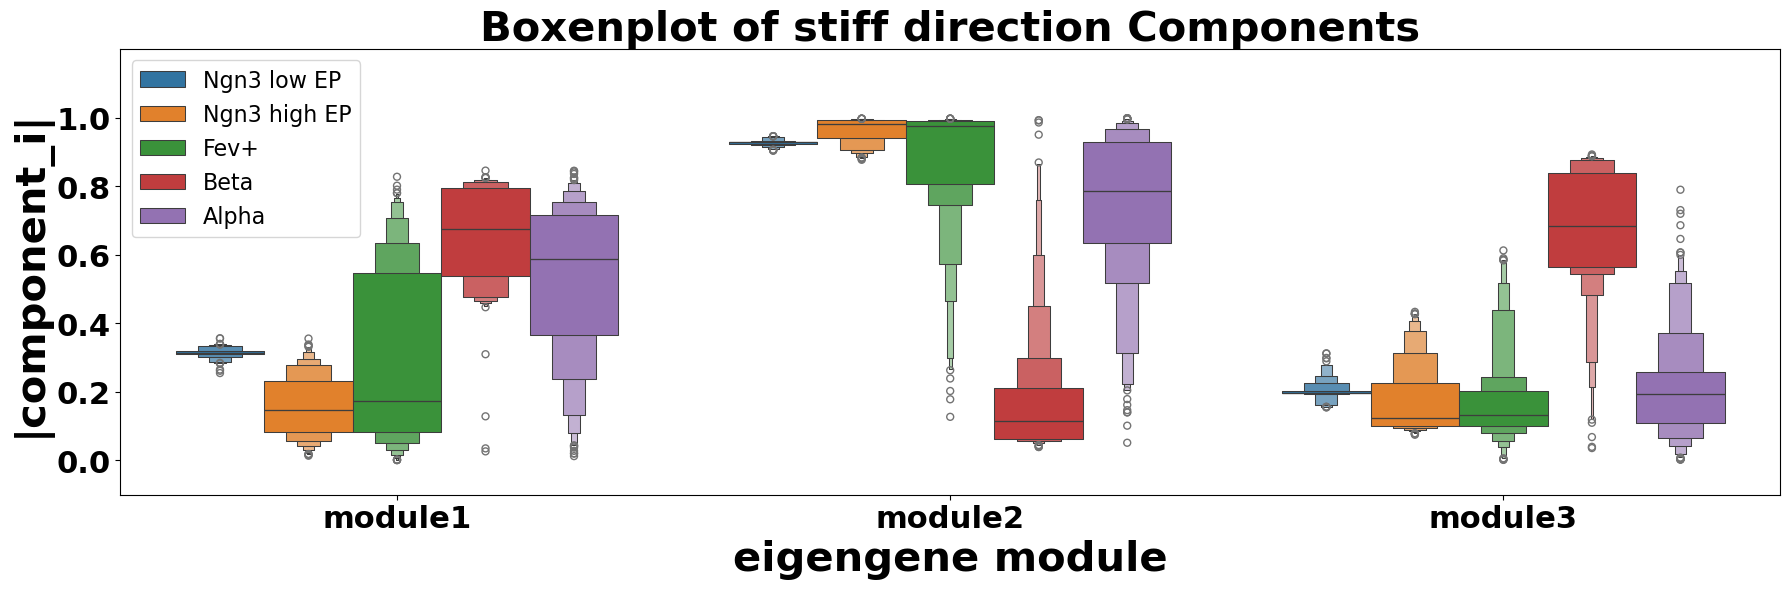

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
# 假设 data_dict 已给定
records = []
for group, mat in eigenvec.items():
    if group == -1:
        continue
    n, d = mat.shape
    for dim in range(d):
        for val in mat[:, dim]:
            records.append({
                'cell type': group,
                '维度': f'module{dim+1}',  # 或直接用数字
                '分量值': np.abs(val)
            })
df = pd.DataFrame(records)
df_cut = df[df['维度'].isin([f'module{i+1}' for i in range(10)])]
plt.figure(figsize=(max(18, len(df_cut['维度'].unique())*3), 6))  # 自动宽度
sns.boxenplot(x='维度', y='分量值', hue='cell type', data=df_cut,hue_order=hue_order)
plt.title('Boxenplot of stiff direction Components', fontsize=30, weight='bold')
plt.yticks([0,0.2,0.4,0.6,0.8,1], fontsize=22, weight='bold')
plt.xticks(fontsize=22, weight='bold')
plt.ylim(-0.1,1.2)
plt.xlabel(f'{new_para_name} module', fontsize=30, weight='bold')
plt.ylabel('|component_i|', fontsize=30, weight='bold')
plt.legend(fontsize=16,loc='upper left')

plt.tight_layout()
plt.savefig(result_path_eigenvec+'Boxenplot of Eigenvec Components.png', bbox_inches='tight')
plt.show()

In [60]:
# from sklearn.neighbors import KernelDensity
# from scipy.special import logit, expit  # expit为logistic函数
# import numpy as np
# if new_para_name != '':
#     for j in categories:
#         for i in range(X.shape[1]):
#             plt.hist(np.abs(Eigenvec[clusters==j][:,i]), bins=30, alpha=0.2, edgecolor='black', label='Frequency Histogram')

#             # 添加标题和标签
#             plt.title(f'Frequency Histogram of {j}', fontsize=18,weight='bold')
#             plt.xlabel(f'Absolute Value on {new_para_name}_{i}', fontsize=16,weight='bold')
#             plt.ylabel('Frequency', fontsize=16,weight='bold')
#             plt.xlim(0,1)
#             # plt.twinx()
#             # # logit变换（避免0和1：可加小epsilon以防数值溢出）
#             # eps = 1e-6
#             # X_trans = logit(np.clip(np.array(np.abs(Eigenvec[clusters==j][:,i])), eps, 1-eps))[:, None]

#             # kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X_trans)

#             # # 评估，在(0,1)区间采样
#             # x_plot = np.linspace(0.001, 0.999, 1000)
#             # z_plot = logit(x_plot)[:, None]
#             # log_dens = kde.score_samples(z_plot)
#             # # 做雅可比修正（链式法则）：pdf(x) = pdf(z) * |dz/dx|，而dz/dx = 1/(x*(1-x))
#             # dens = np.exp(log_dens) / (x_plot*(1-x_plot))
#             # plt.plot(x_plot, dens, '-r', linewidth=2)
#             plt.savefig(result_path_eigenvec+f'Frequency of Eigenvec_{j}_{i}.png',bbox_inches='tight')
#             plt.show()
#             # plt.savefig(result_path+'Frequency of Eigenvec.png',bbox_inches='tight')
#             # plt.legend()